<a href="https://colab.research.google.com/github/isabellacadisco/I-hate-you-P7-/blob/main/P7_textsent_es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets evaluate accelerate
#!pip install optuna
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 10.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (4

In [2]:
from datasets import load_dataset
from datasets.dataset_dict import DatasetDict
import evaluate

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import Trainer
from transformers import TrainingArguments
from transformers import TrainerCallback
from transformers.utils import logging
from transformers import EarlyStoppingCallback
from transformers import pipeline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
from copy import deepcopy
import shap

In [55]:
import numpy as np


data from:
https://github.com/valeriavla/workshop_misogyny

labeled_tweets.csv


In [3]:
# To read the data from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path_es = '/content/drive/MyDrive/misoginy_det/labeled_tweets.csv'

data_es = load_dataset("csv", data_files=path_es)

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
data_es = data_es.remove_columns(['Unnamed: 0'])

In [6]:
data_es

DatasetDict({
    train: Dataset({
        features: ['tweets', 'label'],
        num_rows: 10029
    })
})

In [7]:
data = data_es['train'].train_test_split(test_size=0.2, seed=42)

In [8]:
data = data.rename_column("tweets", "text")
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8023
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2006
    })
})

In [9]:
data['train'][0]

{'text': 'la mujer se convierte en algo que vender y no en alguien',
 'label': 1}

In [10]:
id2label = {0: "Nonmisogynistic", 1: "Misogynistic"}
label2id = {"Nonmisogynistic": 0, "Misogynistic": 1}

label distribution, only train and test, no hyperparameters optimization

In [11]:
pd_train = data['train'].to_pandas()
pd_test = data['test'].to_pandas()

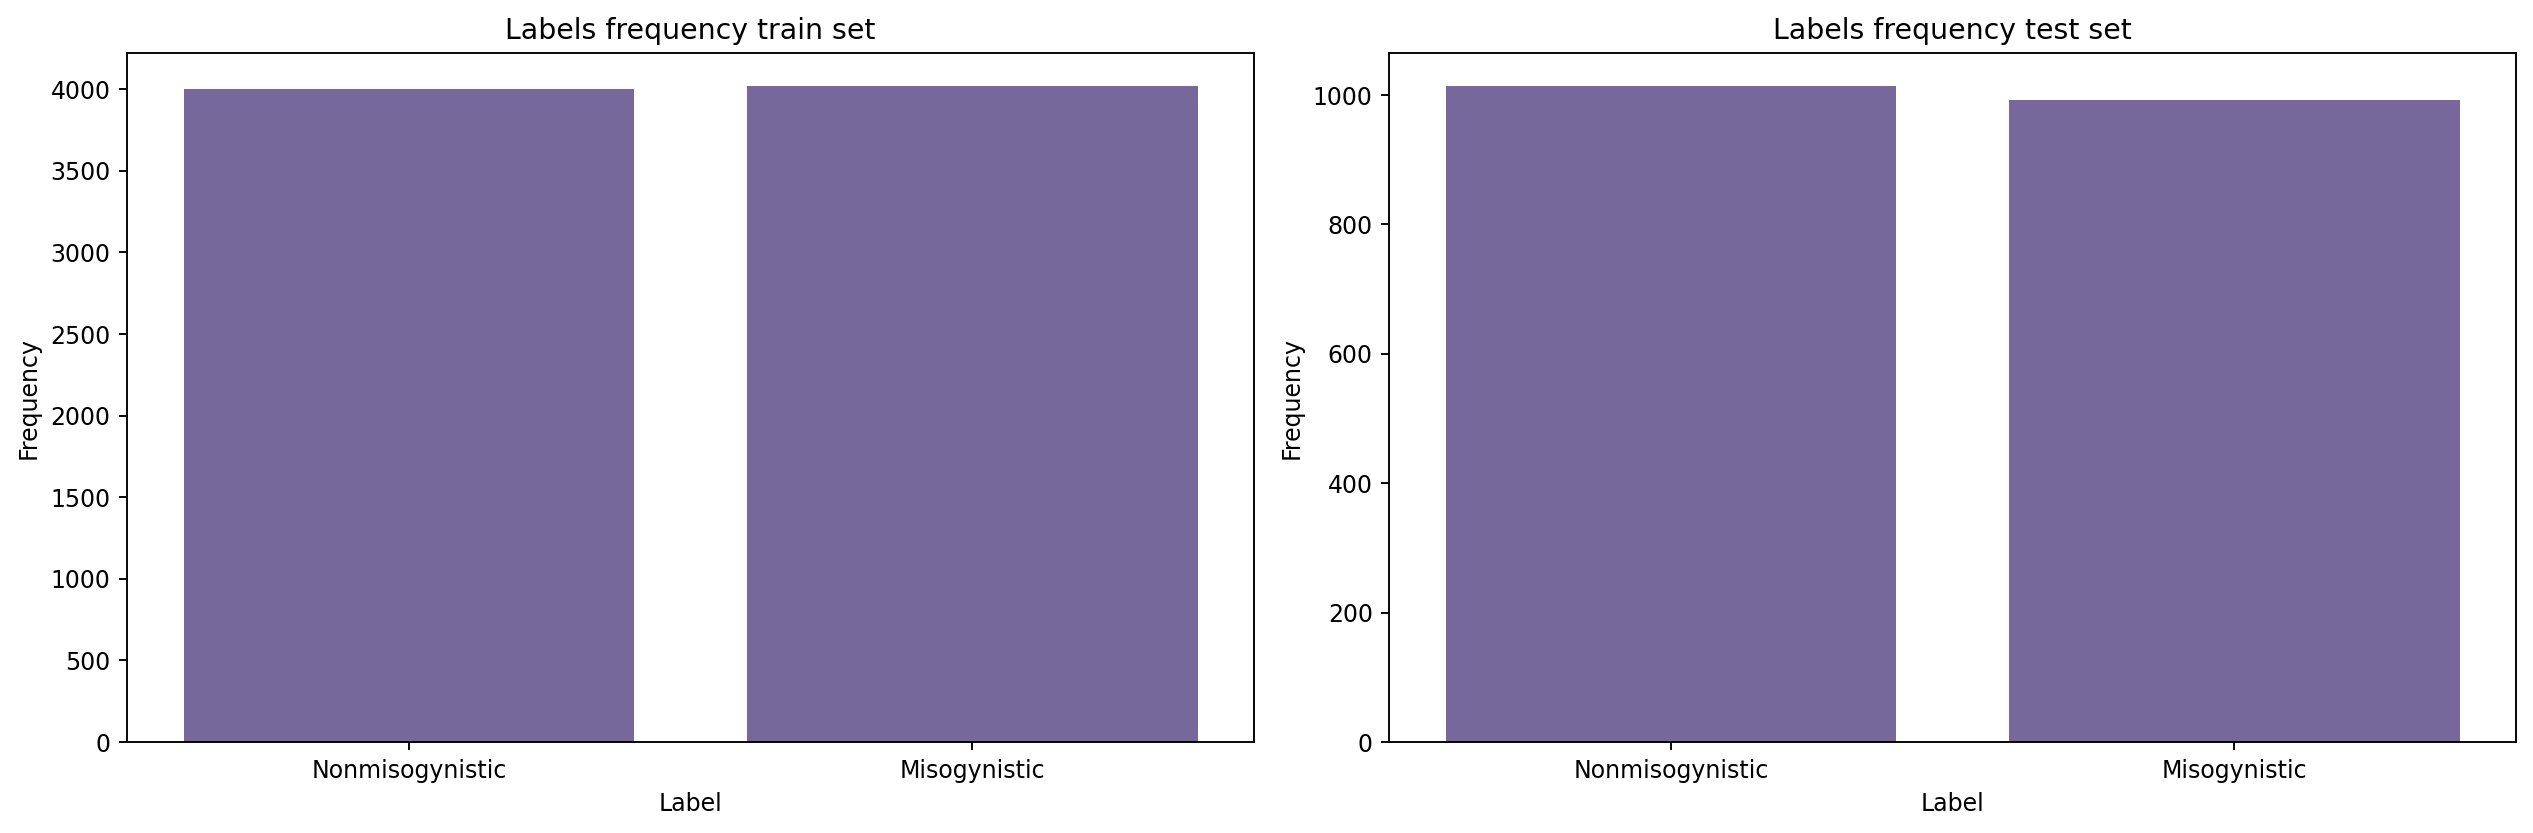

In [12]:
plt.figure(figsize=(15, 5),dpi =170)

# Plot for pd_train
plt.subplot(1, 2, 1)
sns.countplot(data=pd_train, x='label', color = "#7360a3")
plt.title('Labels frequency train set')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=["Nonmisogynistic", "Misogynistic"])

# Plot for pd_validation
plt.subplot(1, 2, 2)
sns.countplot(data=pd_test, x='label', color = "#7360a3")
plt.title('Labels frequency test set')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=["Nonmisogynistic", "Misogynistic"])

plt.tight_layout()
plt.show()

In [13]:
tokenizer = AutoTokenizer.from_pretrained("partypress/partypress-monolingual-spain")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/736k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [16]:
def remove_none_rows(example):
    return example["text"] is not None

data = data.filter(remove_none_rows)

Filter:   0%|          | 0/8023 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2006 [00:00<?, ? examples/s]

In [17]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

In [18]:
tokenized = data.map(preprocess_function, batched=True)

Map:   0%|          | 0/8023 [00:00<?, ? examples/s]

Map:   0%|          | 0/2006 [00:00<?, ? examples/s]

In [19]:
tokenized

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8023
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2006
    })
})

In [22]:
print(tokenized['test'][377]['text'])
print(tokenized['test'][377]['label'])

la única diferencia que existe entre un capricho y una pasión eterna es que el capricho es más duradero
0


In [23]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [24]:
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")


In [25]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # compute
    accuracy_value = accuracy.compute(predictions=predictions, references=labels)
    f1_value = f1.compute(predictions=predictions, references=labels)
    precision_value = precision.compute(predictions=predictions, references=labels)
    recall_value = recall.compute(predictions=predictions, references=labels)

    # return metrics as dict
    return {
        "accuracy": accuracy_value['accuracy'],
        "f1": f1_value['f1'],
        "precision": precision_value['precision'],
        "recall": recall_value['recall']
    }


In [26]:
logger = logging.get_logger(__name__)

In [27]:
class Custom_EarlyStoppingCallback(EarlyStoppingCallback):

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        metric_to_check = args.metric_for_best_model
        if not metric_to_check.startswith("eval_"):
            metric_to_check = f"eval_{metric_to_check}"
        metric_value = metrics.get(metric_to_check)

        if metric_value is None:
            logger.warning(
                f"early stopping required metric_for_best_model, but did not find {metric_to_check} so early stopping"
                " is disabled"
            )
            return

        self.check_metric_value(args, state, control, metric_value)
        if self.early_stopping_patience_counter >= self.early_stopping_patience:
            print('EARLY STOPPING CALLED!')
            control.should_training_stop = True

not correct to use same hyperparameters as distilbert for english, but would like to speed up process and see if something interesting is detected from a lexical point of view.

also, only the learning rate was optimized

In [28]:
args_best = TrainingArguments(
    output_dir="/content/drive/MyDrive/misoginy_det/best_model_es",

    num_train_epochs=12,
    weight_decay = 0.01,
    learning_rate = 1.5e-5,

    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model = 'eval_recall', # bavoid FN
    load_best_model_at_end=True,
    push_to_hub=False,

    logging_first_step=True,
    fp16=True,
    auto_find_batch_size=True,
)


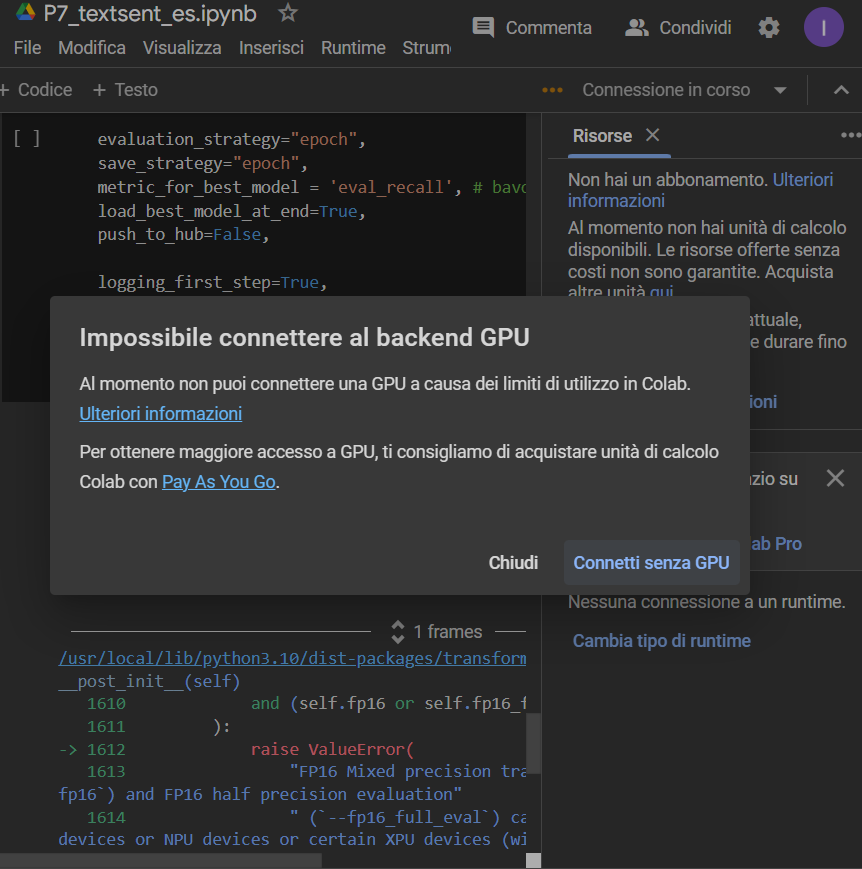

modello che stavo cercando di usare:

https://huggingface.co/partypress


In [29]:
model = AutoModelForSequenceClassification.from_pretrained(
    "partypress/partypress-monolingual-spain",
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.94k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

RuntimeError: Error(s) in loading state_dict for BertForSequenceClassification:
	size mismatch for classifier.weight: copying a param with shape torch.Size([23, 768]) from checkpoint, the shape in current model is torch.Size([2, 768]).
	size mismatch for classifier.bias: copying a param with shape torch.Size([23]) from checkpoint, the shape in current model is torch.Size([2]).
	You may consider adding `ignore_mismatched_sizes=True` in the model `from_pretrained` method.

the model im loading was trained for 23 classes, my model needs to have 2 classes (misogynistic or not), so i can load the embedding and encoding layers of the model but randomly initialize the classification head.
to have the weights of the classification head randomly initialized was the same i was doing when loading distilbert for the english dataset.

the message i was getting when loading distilbert was:

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

which is the same im getting here

In [30]:
model = AutoModelForSequenceClassification.from_pretrained(
    "partypress/partypress-monolingual-spain",
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at partypress/partypress-monolingual-spain and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([23, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([23]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


here im using the test set in place of the validation cause im doing no HPO.
the early stopping will be called if no improvement in the test recall will show, also the best model loaded at the end will the the one with the best recall for the test set.

In [31]:
trainer_best = Trainer(
    model=model,
    args=args_best,
    train_dataset=tokenized['train'],
    eval_dataset=tokenized['test'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks = [Custom_EarlyStoppingCallback(early_stopping_patience=2,
                                              early_stopping_threshold=0.01)]
)

In [32]:
train_best_results = trainer_best.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.365200,0.352572,0.870389,0.869478,0.866000,0.872984
2,0.238600,0.490135,0.875872,0.878120,0.853473,0.904234
3,0.132500,0.676834,0.871884,0.874328,0.849003,0.901210
4,0.070000,0.822801,0.869890,0.867176,0.875642,0.858871


EARLY STOPPING CALLED!


In [33]:
trainer_best.save_model('/content/drive/MyDrive/misoginy_det/best_model_es/model')

In [34]:
trainer_best.evaluate()

EARLY STOPPING CALLED!


{'eval_loss': 0.4901353716850281,
 'eval_accuracy': 0.8758723828514456,
 'eval_f1': 0.8781204111600587,
 'eval_precision': 0.8534728829686014,
 'eval_recall': 0.9042338709677419,
 'eval_runtime': 30.0589,
 'eval_samples_per_second': 66.736,
 'eval_steps_per_second': 8.35,
 'epoch': 4.0}

In [35]:
predictions = trainer_best.predict(tokenized['test'])

In [36]:
predictions

PredictionOutput(predictions=array([[ 2.0097656, -1.7519531],
       [ 3.3222656, -3.2753906],
       [ 3.3378906, -3.3027344],
       ...,
       [ 2.7929688, -2.78125  ],
       [-2.703125 ,  2.6699219],
       [-2.5839844,  2.6757812]], dtype=float32), label_ids=array([0, 0, 0, ..., 0, 1, 1]), metrics={'test_loss': 0.4901353716850281, 'test_accuracy': 0.8758723828514456, 'test_f1': 0.8781204111600587, 'test_precision': 0.8534728829686014, 'test_recall': 0.9042338709677419, 'test_runtime': 31.645, 'test_samples_per_second': 63.391, 'test_steps_per_second': 7.932})

In [37]:
predicted_labels = np.argmax(predictions.predictions, axis=1)
ground_truth_labels = predictions.label_ids

In [38]:
def print_confusion_matrix(predictions, labels):

    cm = confusion_matrix(labels, predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Non-misogynistic", "Misogynistic"],
                yticklabels=["Non-misogynistic", "Misogynistic"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


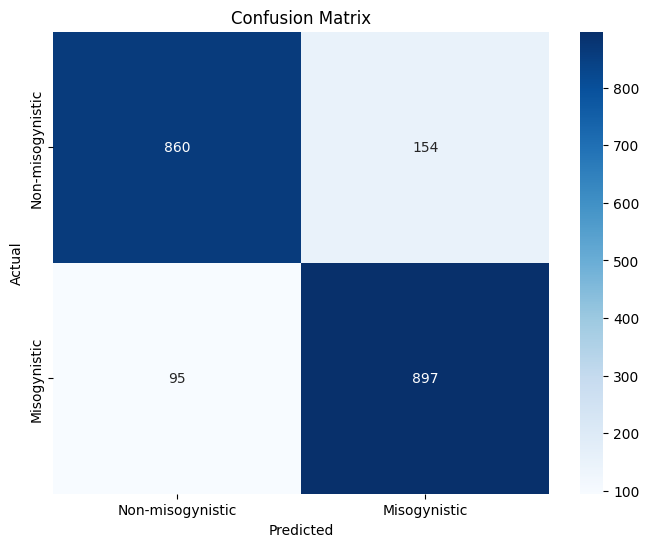

In [39]:
print_confusion_matrix(predicted_labels, ground_truth_labels)

In [40]:
def print_confusion_matrix_normalize(predictions, labels):

    cm = confusion_matrix(labels, predictions, normalize="true")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=["Non-misogynistic", "Misogynistic"],
                yticklabels=["Non-misogynistic", "Misogynistic"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


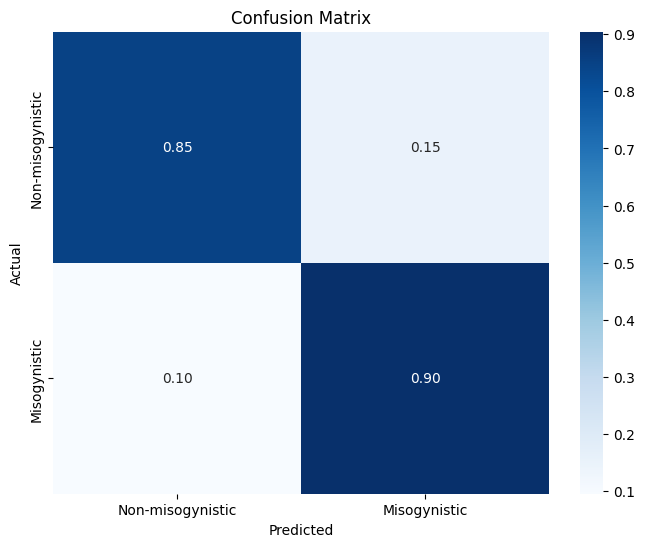

In [41]:
print_confusion_matrix_normalize(predicted_labels, ground_truth_labels)

## Shap explanation

In [42]:
torch.cuda.empty_cache()

In [43]:
best_model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/misoginy_det/best_model_es/model',
    id2label=id2label,
    label2id=label2id,).cuda()

In [44]:
# build a pipeline object to do predictions
pred = pipeline(
    "text-classification",
    model=best_model,
    tokenizer=tokenizer,
    device=0,
    top_k=None,
)

In [45]:
explainer = shap.Explainer(pred)

explain test examples classified as misogynistic

In [54]:
np.shape(predictions.predictions)

(2006, 2)

In [56]:
np.shape(predicted_labels)

(2006,)

In [57]:
predicted_labels

array([0, 0, 0, ..., 0, 1, 1])

In [58]:
indices = np.where(predicted_labels == 1)[0]

In [62]:
data['test']

Dataset({
    features: ['text', 'label'],
    num_rows: 2006
})

In [64]:
test_data_predicted_mis = data['test'][indices]

In [66]:
type(test_data_predicted_mis)

dict

In [68]:
len(test_data_predicted_mis['text'])

1051

In [76]:
shap_values = explainer(test_data_predicted_mis['text'][:40])

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▎     | 17/40 [00:30<00:31,  1.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▎    | 21/40 [00:40<00:31,  1.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▎   | 25/40 [00:50<00:26,  1.77s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 35/40 [01:07<00:06,  1.21s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 41it [01:23,  2.19s/it]


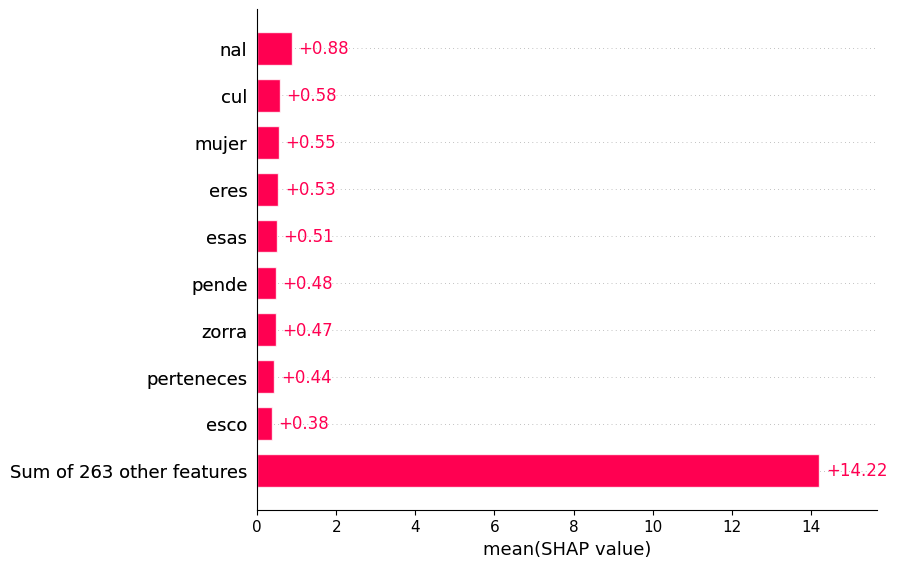

In [77]:
shap.plots.bar(shap_values[:, :, "Misogynistic"].mean(0))

In [78]:
# values for more example

shap_values_big = explainer(test_data_predicted_mis['text'][:200])

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 3/200 [00:15<03:32,  1.08s/it]

  0%|          | 0/156 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▋         | 13/200 [00:42<07:42,  2.47s/it]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 17/200 [00:50<05:37,  1.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 21/200 [01:00<05:24,  1.81s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▎        | 25/200 [01:10<05:23,  1.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 35/200 [01:29<03:22,  1.22s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 46/200 [01:49<03:38,  1.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 50/200 [01:59<04:24,  1.77s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▋       | 53/200 [02:08<05:23,  2.20s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  29%|██▉       | 58/200 [02:20<05:20,  2.26s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|██▉       | 59/200 [02:26<08:00,  3.41s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 61/200 [02:34<08:12,  3.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 64/200 [02:42<05:54,  2.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▋      | 73/200 [02:58<02:30,  1.19s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 74/200 [03:04<05:15,  2.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 75/200 [03:09<07:05,  3.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|███▉      | 79/200 [03:18<03:56,  1.95s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▎     | 87/200 [03:34<03:05,  1.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 88/200 [03:39<05:18,  2.84s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 96/200 [03:57<02:33,  1.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 103/200 [04:08<01:26,  1.12it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▍    | 109/200 [04:24<02:54,  1.92s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 112/200 [04:35<04:06,  2.80s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  62%|██████▏   | 123/200 [04:55<01:01,  1.26it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 129/200 [05:14<02:36,  2.20s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▋   | 133/200 [05:23<02:16,  2.03s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 136/200 [05:35<03:20,  3.14s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 137/200 [05:41<04:21,  4.15s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|██████▉   | 139/200 [05:48<03:36,  3.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 141/200 [05:57<03:44,  3.81s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 143/200 [06:03<03:00,  3.17s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 144/200 [06:09<03:41,  3.96s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 166/200 [06:42<00:26,  1.26it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 168/200 [06:48<00:58,  1.82s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▋ | 173/200 [07:03<00:50,  1.86s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 175/200 [07:10<01:01,  2.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 176/200 [07:16<01:25,  3.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████ | 182/200 [07:28<00:28,  1.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  94%|█████████▍| 188/200 [07:40<00:14,  1.19s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 191/200 [07:50<00:22,  2.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|█████████▉| 199/200 [08:02<00:00,  1.08it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 201it [08:13,  2.47s/it]


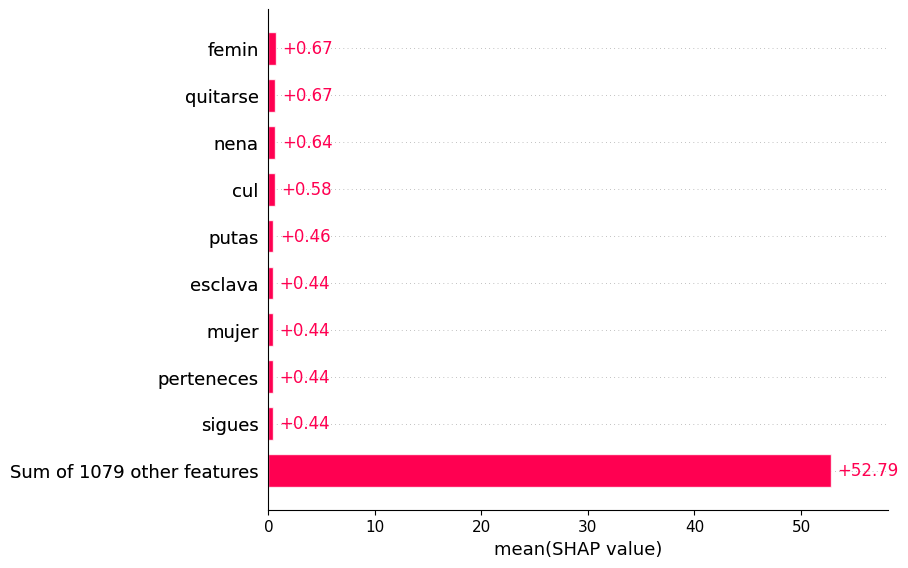

In [79]:
shap.plots.bar(shap_values_big[:, :, "Misogynistic"].mean(0))

In [80]:
shap.plots.text(shap_values[:, :, "Misogynistic"])